In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import pandas as pd
import seaborn as sns; sns.set()
import sklearn
from sklearn.metrics import confusion_matrix

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from sklearn.model_selection import train_test_split

my_data_dir = 'Colab Notebooks'
data = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/first24hrs_o2.npy")
labels = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/label_mort_o2.npy")

data_b, data_test, label_b, labels_test = train_test_split(data, labels, test_size=0.20, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_b, label_b, test_size=0.25, random_state=42)

In [0]:
#view data
print(labels_train.mean(), labels_val.mean(), labels_test.mean())
print(data_train.shape, data_val.shape, data_test.shape)

0.08475006343567622 0.08119766556711494 0.0763765541740675
(11823, 24, 10) (3941, 24, 10) (3941, 24, 10)


In [0]:
#Collapse data for description
#Spit into two class
pos_data = data_train[labels_train != 0]
neg_data = data_train[labels_train == 0]
neg = len(neg_data)
pos_data= np.reshape(pos_data,(pos_data.shape[0]*pos_data.shape[1],pos_data.shape[2]))
neg_data= np.reshape(neg_data,(neg_data.shape[0]*neg_data.shape[1],neg_data.shape[2]))

pos_data.shape, neg_data.shape, neg


((24048, 10), (259704, 10), 10821)

In [0]:
#Statistics for positive case
columns = ['HR','SBP','DBP','mean_BP','RR','BT','SpO2','Glu','MV','O2']
res = pos_data.mean(axis=0)
for r,c in zip(columns, res):
  print(r,c)

HR 0.2395524494423593
SBP -0.21337060491157572
DBP -0.13377010259861602
mean_BP -0.15048823656320104
RR 0.3678487299789584
BT -0.11929862736459781
SpO2 -0.004749930242274548
Glu 0.10607733858017236
MV 0.5103127079174984
O2 0.3309630738522954


In [0]:
# Stats for neg
res = neg_data.mean(axis=0)
for r,c in zip(columns, res):
  print(r,c)

HR -0.024723704980158356
SBP 0.024942910747902492
DBP 0.03123493621917208
mean_BP 0.009329693169816132
RR -0.009533324177121378
BT 0.01434967657140449
SpO2 0.00032861688379506735
Glu -0.09068452095850761
MV 0.24670393987000586
O2 0.4356806210146936


In [0]:
# Create dataset for single data point at 24hr after admission
data_train_point = data_train[:,-1,:]
data_val_point = data_val[:,-1,:]
data_test_point = data_test[:,-1,:]
data_train_point.shape, data_val_point.shape, data_test_point.shape

((11823, 10), (3941, 10), (3941, 10))

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
  # project from 8 to 2 dimensions
projected = pca.fit_transform(data_test_point)
print(data_test_point.shape)
print(projected.shape)

(3941, 10)
(3941, 2)


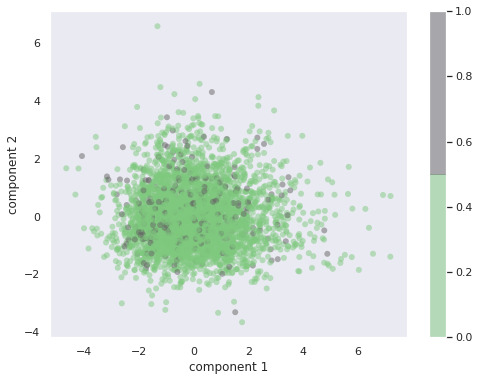

In [0]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=labels_val, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
# Create dataset contains only eight parameters 
data_train5 = data_train[:,:,:-2]
data_val5 = data_val[:,:,:-2]
data_test5 = data_test[:,:,:-2]
print(data_train5.shape, data_val5.shape, data_test5.shape)

# at 24hr after admission
data_train_point5 = data_train5[:,-1,:]
data_val_point5 = data_val5[:,-1,:]
data_test_point5 = data_test5[:,-1,:]
data_train_point5.shape, data_val_point5.shape, data_test_point5.shape

(11823, 24, 8) (3941, 24, 8) (3941, 24, 8)


((11823, 8), (3941, 8), (3941, 8))

In [0]:
# Create dataset
def Create_dataset(data, label, BATCH_SIZE = 128):
  tf.random.set_seed(0)
  dataset = tf.data.Dataset.from_tensor_slices((data, label))
  dataset = dataset.batch(BATCH_SIZE).prefetch(2)
  return dataset

def Resample_dataset(data, label, BATCH_SIZE = 128,BUFFER_SIZE = 10000):
  tf.random.set_seed(0)
  pos_labels = label[label != 0]
  neg_labels = label[label == 0]
  pos_data = data[label != 0]
  neg_data = data[label == 0]

  pos_ds = tf.data.Dataset.from_tensor_slices((pos_data, pos_labels))
  pos_ds = pos_ds.cache().shuffle(BUFFER_SIZE).repeat()

  neg_ds= tf.data.Dataset.from_tensor_slices((neg_data, neg_labels))
  neg_ds = neg_ds.cache().shuffle(BUFFER_SIZE).repeat()

  resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
  resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
  return resampled_ds

In [0]:
valset = Create_dataset(data_val_point, labels_val)
testset = Create_dataset(data_test_point, labels_test)
resampled_ds = Resample_dataset(data_train_point,labels_train)

In [0]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4453125


In [0]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
]

In [0]:
regression = tf.keras.Sequential([
      tf.keras.layers.Dense(
          1, activation='sigmoid',
          input_shape=(data_train_point.shape[-1],))
  ])

regression.compile(
      optimizer=tf.keras.optimizers.Adam(lr=3e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
regression.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [0]:
EPOCHS = 1000
BATCH_SIZE = 128
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [0]:
regression_history = regression.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping


In [0]:
def plot_metrics(history):
  mtx =  ['loss', 'auc', 'precision', 'recall']
  for n, m in enumerate(mtx):
    n+=1 
    plt.subplot(2,2,n)
    plt.plot(history.epoch,  history.history[m], label='Train')
    plt.plot(history.epoch, history.history['val_'+m],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(m)
    if m == 'loss':
      plt.ylim([0.2, plt.ylim()[1]])
    elif m == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()


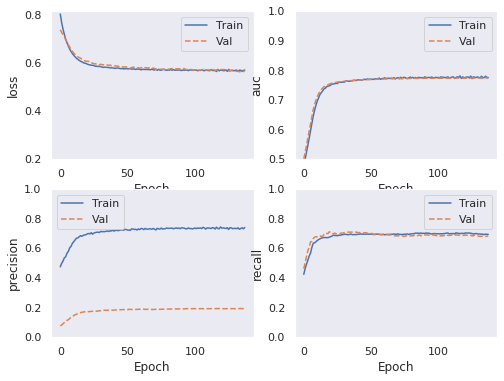

In [0]:
plot_metrics(regression_history)

In [0]:
def plot_cm(labels, predictions, prob=0.5):
  cm = confusion_matrix(labels, predictions > prob)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(prob))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Total Survival: ', np.sum(cm[0]))
  print('Total Mortality: ', np.sum(cm[1])) 
  print('Postivie Predictive Value (Precision): ', cm[1][1]/(cm[1][1]+cm[0][1]))
  print('Sensitivity (Recall): ', cm[1][1]/np.sum(cm[1]))
  print()


loss :  0.5619408456815194
accuracy :  0.7561533
auc :  0.79212517
precision :  0.19387755
recall :  0.69435215
tp :  209.0
fp :  869.0
tn :  2771.0
fn :  92.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.19387755102040816
Sensitivity (Recall):  0.6943521594684385



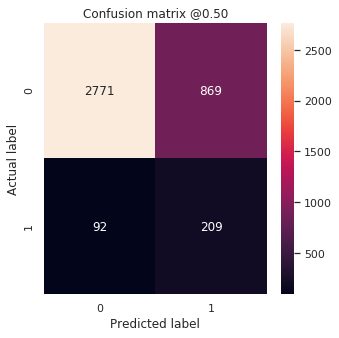

In [0]:
train_regression_predictions = regression.predict(data_train_point, batch_size=BATCH_SIZE)
test_regression_predictions = regression.predict(data_test_point, batch_size=BATCH_SIZE)

regression_results = regression.evaluate(data_test_point, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(regression.metrics_names, regression_results):
  print(name, ': ', value)
print()

plot_cm(labels_test, test_regression_predictions)

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('1 - Speficity [%]')
  plt.ylabel('Sensitivity [%]')
  #plt.xlim([-0.5,100])
  #plt.ylim([30,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [0]:
FFN = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(data_train_point.shape[-1],)),
      tf.keras.layers.Dense(
          16, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid')
                        
  ])

FFN.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
FFN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                176       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [0]:
FFN_history = FFN.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


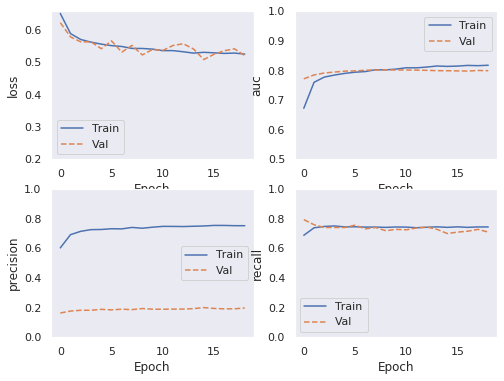

In [0]:
plot_metrics(FFN_history)

In [0]:
train_FFN_predictions = FFN.predict(data_train_point, batch_size=BATCH_SIZE)
test_FFN_predictions = FFN.predict(data_test_point, batch_size=BATCH_SIZE)

loss :  0.5125926815141612
accuracy :  0.74600357
auc :  0.8023981
precision :  0.19081272
recall :  0.717608
tp :  216.0
fp :  916.0
tn :  2724.0
fn :  85.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.19081272084805653
Sensitivity (Recall):  0.717607973421927



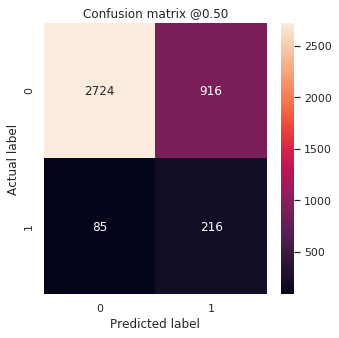

In [0]:
FFN_results = FFN.evaluate(data_test_point, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(FFN.metrics_names, FFN_results):
  print(name, ': ', value)
print()

plot_cm(labels_test, test_FFN_predictions)

In [0]:
# Create dataset for recurrent neural network 
valset = Create_dataset(data_val, labels_val)
testset = Create_dataset(data_test, labels_test)
resampled_ds = Resample_dataset(data_train,labels_train)
for features, label in resampled_ds.take(1):
  print(features.shape,label.shape)

(128, 24, 10) (128,)


In [0]:
data_train.shape[:]

(11823, 24, 10)

In [0]:
#Single later RNN(LSTM)
RNN_single = tf.keras.Sequential([
      tf.keras.layers.LSTM(32,
          input_shape=data_train.shape[-2:]),
      tf.keras.layers.Dense(1, activation='sigmoid')
                        
  ])

RNN_single.compile(
      optimizer=tf.keras.optimizers.Adam(lr=3e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
RNN_single.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 32)                5504      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn_history = RNN_single.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


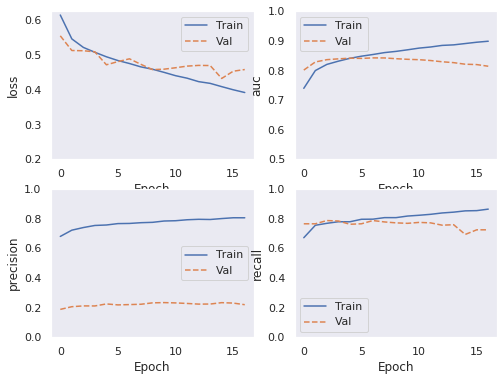

In [0]:
plot_metrics(rnn_history)

In [0]:
train_RNN_predictions = RNN_single.predict(data_train, batch_size=BATCH_SIZE)
test_RNN_predictions = RNN_single.predict(data_test, batch_size=BATCH_SIZE)

loss :  0.4887110566735963
accuracy :  0.7594519
auc :  0.831832
precision :  0.21038496
recall :  0.7807309
tp :  235.0
fp :  882.0
tn :  2758.0
fn :  66.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.21038495971351837
Sensitivity (Recall):  0.7807308970099668



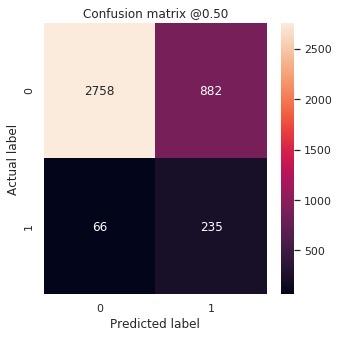

In [0]:
RNN_single_results = RNN_single.evaluate(data_test, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(RNN_single.metrics_names, RNN_single_results):
  print(name, ': ', value)
print()

plot_cm(labels_test, test_RNN_predictions)

In [0]:
#Single later RNN(GRU)
RNNgru_single = tf.keras.Sequential([
      tf.keras.layers.GRU(16, 
          input_shape=data_train.shape[-2:],activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
                        
  ])

RNNgru_single.compile(
      optimizer=tf.keras.optimizers.Adam(lr=3e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
RNNgru_single.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 16)                1344      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnngru_history = RNNgru_single.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping


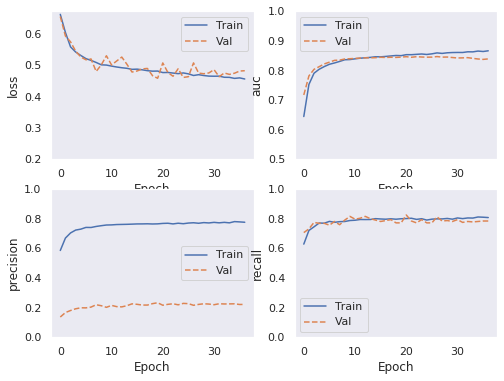

In [0]:
plot_metrics(rnngru_history)

In [0]:
train_GRU_predictions = RNNgru_single.predict(data_train, batch_size=BATCH_SIZE)
test_GRU_predictions = RNNgru_single.predict(data_test, batch_size=BATCH_SIZE)

loss :  0.5093519250259457
accuracy :  0.7500634
auc :  0.8298912
precision :  0.19894366
recall :  0.7508306
tp :  226.0
fp :  910.0
tn :  2730.0
fn :  75.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.198943661971831
Sensitivity (Recall):  0.7508305647840532



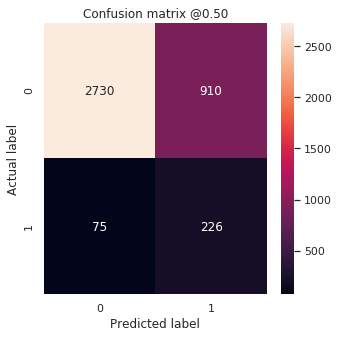

In [0]:
RNNgru_results = RNNgru_single.evaluate(data_test, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(RNNgru_single.metrics_names, RNNgru_results):
  print(name, ': ', value)
print()

plot_cm(labels_test, test_GRU_predictions)

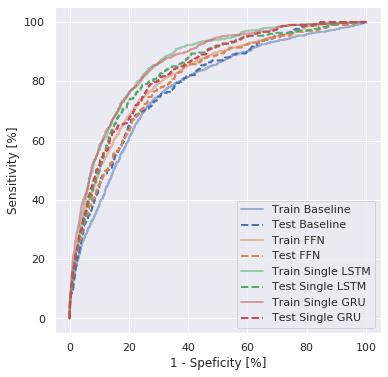

In [0]:
# ROC Plot

plot_roc("Train Baseline", labels_train, train_regression_predictions, color=colors[0],alpha=0.5)
plot_roc("Test Baseline", labels_test, test_regression_predictions,  linestyle='--', color=colors[0])

plot_roc("Train FFN", labels_train, train_FFN_predictions, color=colors[1],alpha=0.5)
plot_roc("Test FFN", labels_test, test_FFN_predictions,  linestyle='--', color=colors[1])

plot_roc("Train Single LSTM", labels_train, train_RNN_predictions, color=colors[2],alpha=0.5)
plot_roc("Test Single LSTM", labels_test, test_RNN_predictions,  linestyle='--', color=colors[2])

plot_roc("Train Single GRU", labels_train, train_GRU_predictions, color=colors[3],alpha=0.5)
plot_roc("Test Single GRU", labels_test, test_GRU_predictions,  linestyle='--', color=colors[3])
plt.legend(loc='lower right')

In [0]:
# multiple layer RNN
RNN_double = tf.keras.Sequential([
      tf.keras.layers.LSTM(16, 
          input_shape=data_train.shape[-2:],
          return_sequences=True),
      tf.keras.layers.LSTM(16, activation='relu'),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

RNN_double.compile(
      optimizer=tf.keras.optimizers.Adam(lr=3e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
RNN_double.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9         
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnnd_history = RNN_double.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


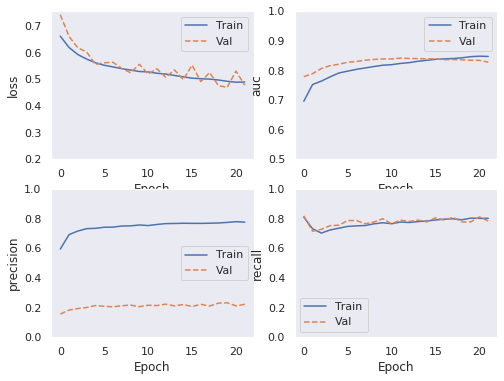

In [0]:
plot_metrics(rnnd_history)

In [0]:
train_RNNd_predictions = RNN_double.predict(data_train, batch_size=BATCH_SIZE)
test_RNNd_predictions = RNN_double.predict(data_test, batch_size=BATCH_SIZE)

loss :  0.542046100377613
accuracy :  0.75361586
auc :  0.82472575
precision :  0.20510563
recall :  0.77408636
tp :  233.0
fp :  903.0
tn :  2737.0
fn :  68.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.2051056338028169
Sensitivity (Recall):  0.7740863787375415



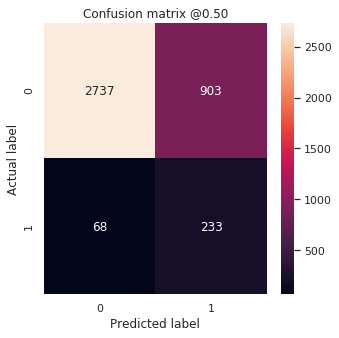

In [0]:
RNN_double_results = RNN_double.evaluate(data_test, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(RNN_double.metrics_names, RNN_double_results):
  print(name, ': ', value)
print()

plot_cm(labels_test, test_RNNd_predictions)

In [0]:
# multiple layer RNN
GRU_double = tf.keras.Sequential([
      tf.keras.layers.GRU(16,
          input_shape=data_train.shape[-2:],
          return_sequences=True),
      tf.keras.layers.GRU(8, activation = 'relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

GRU_double.compile(
      optimizer=tf.keras.optimizers.Adam(lr=3e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
GRU_double.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 24, 16)            1344      
_________________________________________________________________
gru_11 (GRU)                 (None, 8)                 624       
_________________________________________________________________
dense_46 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)               

In [0]:
grud_history = GRU_double.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=valset,
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping


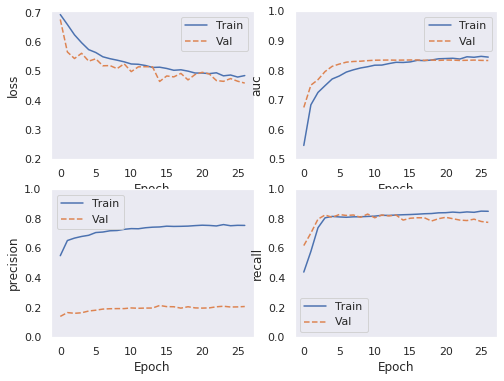

In [0]:
plot_metrics(grud_history)

In [0]:
train_GRUd_predictions = GRU_double.predict(data_train, batch_size=BATCH_SIZE)
test_GRUd_predictions = GRU_double.predict(data_test, batch_size=BATCH_SIZE)

loss :  0.47898271320677444
accuracy :  0.7416899
auc :  0.82456106
precision :  0.19848612
recall :  0.78405315
tp :  236.0
fp :  953.0
tn :  2687.0
fn :  65.0

Total Survival:  3640
Total Mortality:  301
Postivie Predictive Value (Precision):  0.1984861227922624
Sensitivity (Recall):  0.7840531561461794



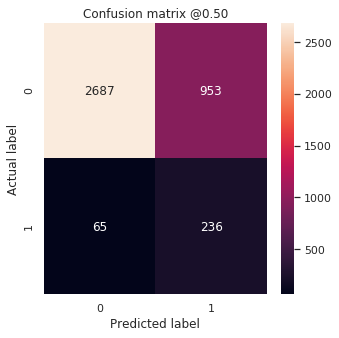

In [0]:
GRU_double_results = GRU_double.evaluate(data_test, labels_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(GRU_double.metrics_names, GRU_double_results):
  print(name, ': ', value)
print()


plot_cm(labels_test, test_GRUd_predictions)

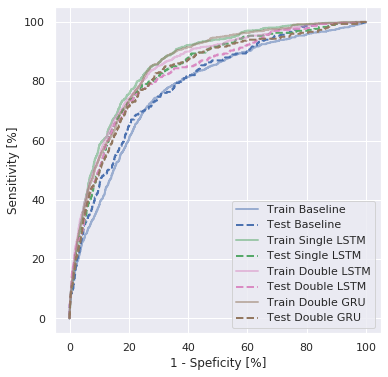

In [0]:
plot_roc("Train Baseline", labels_train, train_regression_predictions, color=colors[0],alpha=0.5)
plot_roc("Test Baseline", labels_test, test_regression_predictions,  linestyle='--', color=colors[0])
plot_roc("Train Single LSTM", labels_train, train_RNN_predictions, color=colors[2],alpha=0.5)
plot_roc("Test Single LSTM", labels_test, test_RNN_predictions,  linestyle='--', color=colors[2])

plot_roc("Train Double LSTM", labels_train, train_RNNd_predictions, color=colors[6],alpha=0.5)
plot_roc("Test Double LSTM", labels_test, test_RNNd_predictions,  linestyle='--', color=colors[6])

plot_roc("Train Double GRU", labels_train, train_GRUd_predictions, color=colors[5],alpha=0.5)
plot_roc("Test Double GRU", labels_test, test_GRUd_predictions,  linestyle='--', color=colors[5])
plt.legend(loc='lower right')